In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense,Dropout, Input
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.models import load_model
# from tensorflow_addons.metrics import RSquare

In [ ]:
data = pd.read_csv("user_20.csv")
columns = data.columns.tolist()
columns = [c for c in columns if c not in ["index","Timestamp","Ps","Pd"]]

target_1 = "Ps"
target_2 = "Pd"


In [ ]:
X = data.drop(columns=["index","Timestamp","Ps","Pd"]).values
y_1 = data.Ps.values
y_2 = data.Pd.values

x_scaler = StandardScaler()
X = x_scaler.fit_transform(X)

y_1_scaler = StandardScaler()
y_1 = y_1_scaler.fit_transform(y_1.reshape(-1,1))

y_2_scaler = StandardScaler()
y_2 = y_2_scaler.fit_transform(y_2.reshape(-1,1))

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y_1,test_size=0.2)


In [ ]:
n_features = X.shape[1]
dropout_proba = 0.25
batch_size = 64
opt = SGD(learning_rate=0.01)
epochs = 5000

In [ ]:
def DNN_model_with_dropout(layers_shape, input_dim, dropout_proba, act='relu'):
    inputs = Input(shape=(input_dim,))
    hidden = Dense(layers_shape[0], activation=act)(inputs)
    for i in range(len(layers_shape)-1):
        if dropout_proba > 0:
            hidden = Dropout(dropout_proba)(hidden, training=True)
        hidden = Dense(layers_shape[i+1], activation=act)(hidden)
    if dropout_proba > 0:
        hidden = Dropout(dropout_proba)(hidden, training=True)
    outputs = Dense(units = 1, kernel_initializer = 'uniform', activation = 'linear')(hidden)
    model = Model(inputs, outputs)
    return model

model = DNN_model_with_dropout([64,32,16],n_features, dropout_proba, act='relu')
model.compile(optimizer = opt,loss="mse",metrics=[RootMeanSquaredError()])
print(model.summary)
history = model.fit(X_train,y_train,batch_size=batch_size,epochs=epochs,verbose=0)

<bound method Model.summary of <keras.engine.functional.Functional object at 0x7f244418f070>>


In [ ]:
def DNN_uncertainity(model, x_test,T=500):
    predictions = []
    for _ in range(T):
        predictions += [model.predict(x_test,verbose=0)]
        #return predictions
    mean, std = np.mean(np.array(predictions), axis=0), np.std(np.array(predictions), axis=0)
    return mean,std

In [ ]:
y_pred, sigma = DNN_uncertainity(model, X_test,T=500)
print("Model score:",r2_score(y_test,y_pred))

Model score: 0.7103944481324695


In [ ]:
Ps_vals = np.linspace(data.index.min(),data.index.max(),1000)
df_plot = pd.DataFrame(Ps_vals,columns=['index'])
for col in data.columns:
    if col!= 'index':
        df_plot[col] = data[col].iloc[0] #Just to demonstrate for a datapoint, will plot for the 1st datapoint
df_plot = df_plot[data.columns]

In [ ]:
y_pred, sigma = DNN_uncertainity(model, x_scaler.transform(df_plot.drop(columns=["index","Timestamp","Ps","Pd"]).values),T=500)

y_pred, sigma = y_pred.reshape(-1,), sigma.reshape(-1,)
sigma = y_1_scaler.inverse_transform(sigma.reshape(-1,1)) - np.mean(data.Ps.values,axis=0)
sigma = sigma.reshape(1,-1)[0]
df_plot["Ps_pred"] = y_1_scaler.inverse_transform(y_pred.reshape(-1,1))

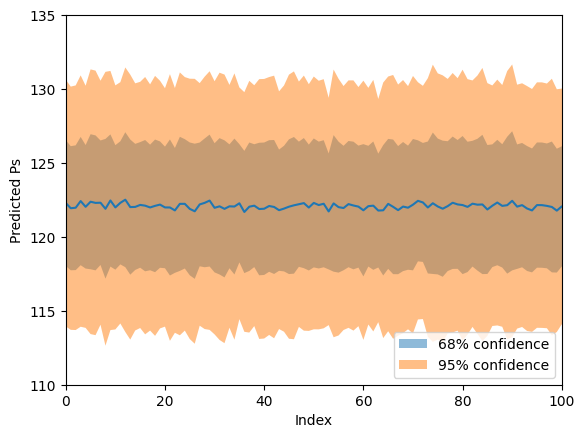

In [ ]:
plt.plot(df_plot.index.values,df_plot.Ps_pred.values)
plt.fill_between(df_plot.index.values, df_plot.Ps_pred.values-1*sigma, df_plot.Ps_pred.values+1*sigma, alpha=.5,label='68% confidence')
plt.fill_between(df_plot.index.values, df_plot.Ps_pred.values-1.96*sigma, df_plot.Ps_pred.values+1.96*sigma, alpha=.5,label='95% confidence')
plt.legend(loc='lower right')
plt.ylabel('Predicted Ps')
plt.xlabel('Index')
plt.ylim([110, 135])
plt.xlim([0,100])
plt.show()

In [ ]:
model.save("Ps_2.h5")